# Ryan Gough 


### Social Media Sentiment Analysis of Publicly Traded Firms

The Proposal

The financial market is something which I have a continued enthusiasm for, as well as professional interest as I believe machine learning and the financial sector will be linked tighter as innovation increases. Traditionally, Quants have held special positions on Wall Street per their expertise in the field. Statisticians by nature and aided by computer technology the field has continued to change in the past two decades. In just the past decade as machine learning has expanded and Wall Street eager to adapt new technologies. Retail investors now being more programming and computer literate have a new opportunity to level the playing field somewhat with machine learning. Sentiment Analysis has provided the financial sector a new place to mine for information. As the currency of any age is information, gaining that information in the right hands can make many people wealthy. Retail investors can also mine this information to determine which way a stock is headed. Mining social media platforms enable us to find the right information at the right time.  The business problem is getting the information before a large portion of investors can begin to move into the market. For example, if sentiment dictates that there is a downward shift in a firm, you could be able to sell off your shares before it gets reported on CNBC or the WSJ where “normal” investors would react to this news. 

I intend to create a program that can analyze user sentiment in social media platforms. I believe Reddit would be a better option due to the character limits of Twitter. Whereas in Reddit, a more general discussion would be able to take place. The objective will be to assess whether user sentiment from social media can reliably predict market trends. If they do, how soon before a market event occurs. Additionally, if the social media sentiment precedes a market event. What would be the timing difference between major news outlets and social media groups. Arguably, the saying goes if it’s on the news, you missed out. So, seeing if social media has a better pulse on the market would be a business venture to pursue if you can see market trends before they occur. I have seen several things that are similar but not quite what I am proposing. I hope this is an interesting enough idea. I’ve been wanting to do something like this since the Gamestop event in January. This would be a great opportunity to use the skills I’ve learned to something that people can make decisions on, on a daily basis.


### Data

###### Data Source: Reddit through an API
###### Data Source: CSV of publicly traded firms through the NASDAQ
###### Data Source: Finviz: to obtain aggregated news from outlets

###### Data variables in the file are: Key Name Description


    Ticker - Acronym for firm
    Company_Name - Name of firm
    Last Sale - Closing Price of previous day
    Net Change - Difference between closing prices from one day to the next
    Label - 0: Stock price was down, 1: stock price was up
    % Change - % change in stock price from the morning to the time of observation
    Market Cap - ceiling of value for a given firm
    Country - Country where the firm is located
    IPO Year - Year the firm was listed on the stock market
    Volume - amount of shares being traded for that day
    Sector - the Global Industry Classification Standard (GICS) for a firm
    Industry - a subset of sector
    Frequency - numerical value for mentions within Reddit
    Polarity - Sentiment Analysis value
    Subjectivity - Sentiment Analysis value
    Compound - Sentiment Analysis value
    Negative - Sentiment Analysis value
    Neutral - Sentiment Analysis value
    Positive - Sentiment Analysis value
    News_Sentiment - Sentiment of News outlets


### Libraries for Class Project

In [1]:
# Importing necessary libraries.
import pandas as pd 
import numpy as np
import praw # API Wrapper for Reddit
import re # To scrape text. 
import requests 
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Libraries
# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, roc_auc_score
import datetime
import time
import pandas_profiling

###### I wanted to use a method to dynamically import Reddit data instead of a static csv file.  I believe this method is would be used in a real world setting. Interpreting new data, and refining the method based off the new data.

In [3]:
# API Wrapper for reddit
reddit = praw.Reddit(
    client_id="9J_NKTwiIoYZ7g",
    client_secret="zT9uNM6s19e9J-MdyArE7Ym59vlD6g",
    user_agent="silentbananna",
)

Version 7.2.0 of praw is outdated. Version 7.4.0 was released Friday July 30, 2021.


###### First I created an empty list. Then I iterate through the top 500 topics of the selected subreddit, in this case it is wallstreetbets. It then compartmentalizes Topics in one column, and the comments into another. Resulting in a dataframe of two columns. 

In [4]:
df_list = [] # Created an empty list. 

for post in reddit.subreddit('wallstreetbets').hot(limit=100):
    
    content = {
        "Topic" : post.title,
        "Comment" : post.selftext,
        "Time" : datetime.datetime.now()
    }
    
    df_list.append(content) # Created a for loop which iterates through the top 500 topics on the wallstreetbets subreddit.

df = pd.DataFrame(df_list) # Put the list into a dataframe.

###### I found a really good method for EDA on KDnuggets. Using pandas_profiling, I am able to see a more indepth assessment of the data. 

In [5]:
df.profile_report()

###### I need published news from news outlets. I am using Finviz which is a well known financial website. Finviz agreggates news from multiple sources onto one website. I will scrape this website for relevant firms which are mentioned in Reddit.

In [6]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Parameters 
n = 10 # The # of article headlines displayed per ticker
tickers = ['WISH', 'PLTR', 'G', 'DD', 'SEM', 'AI', 'ARVL', 'CLOV', 'RKT', 'MU', 'M', 'EBAY', 'GNW', 'UWMC', 'NOK', 'AMZN', 'SBUX', 'DIS', 'UPST', 'GME']

In [7]:
# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df_1 = news_tables[ticker]
        df_tr = df_1.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for WISH: 
Why ContextLogic Stock Crashed Today ( Aug-13-21 05:39PM )
Dow, S&P 500 end at records Friday, finish week with longest streak of closing records since March ( 04:40PM )
Disney stock jumps, Airbnb falls, WISH sinks to record low, Bitcoin rebounds above $46K ( 02:45PM )
Wish stock tanks, SoFi profit outlook disappoints, Honest misses on revenue ( 09:54AM )
ContextLogic Stock Only Has One Trade Setup After Earnings Plunge ( 05:30AM )
Premarket Movers Friday: ContextLogic, Disney, SoFi ( 04:15AM )
ContextLogic Plunges As Losses Increase and Users Fall ( 03:27AM )
ContextLogic Stock Plummets on Earnings Miss and Rare Double Downgrade ( 02:42AM )
Wish stock tanks 20% as e-commerce company says demand slowed, costs rose more than expected ( Aug-12-21 08:16PM )
Wish Reports Second Quarter 2021 Financial Results ( 04:07PM )


Recent News Headlines for PLTR: 
2 Robinhood Stocks to Buy in August ( Aug-14-21 06:40AM )
Stock Market Near Highs, Treasury Yields Ral

In [8]:
# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

###### Display the first 5 rows of Reddit data so you can see the column headings and the type of data for each column.

In [9]:
df.head(10) # Get an idea of the data.

,Topic,Comment,Time
0,Weekend Discussion Thread for the Weekend of A...,Your weekend discussion thread. Please keep th...,2021-08-14 12:40:18.862035
1,Most Anticipated Earnings Releases for the wee...,,2021-08-14 12:40:18.862043
2,"The more monitors you have, the better the tra...",,2021-08-14 12:40:18.862046
3,My experience with MVST recently,,2021-08-14 12:40:18.862048
4,How Hitler actually lost WWII,,2021-08-14 12:40:18.862050
5,Robinhood is a scam. I know you know but holy ...,I know it’s my own damn fault for using their ...,2021-08-14 12:40:18.862052
6,Would manny monitors help you make more or los...,,2021-08-14 12:40:18.862054
7,Me trying to negotiate with the market,,2021-08-14 12:40:18.862055
8,I’m just gonna leave this here,,2021-08-14 12:40:18.862057
9,The Senate's $1 trillion bipartisan infrastruc...,The Senate's $1 trillion bipartisan infrastruc...,2021-08-14 12:40:18.862060


In [10]:
print("Summarized Data") # Summarize the data. 
df.describe(include=['O'])

Summarized Data


,Topic,Comment
count,100,100
unique,100,44
top,"Daily Popular Tickers Thread for August 13, 20...",
freq,1,57


##### For Reddit  I seperate the strings and record the frequency in which the words are observed. Additionally, I have listed below words in which to look for and remove. You will notice I did not use a method to remove stopwords. This was intentional as many firm's ticker acronyms typically fall into the domain of stop words as they are shorthand for the company on the NASDAQ. 

In [11]:
regex = re.compile('[^a-zA-Z ]') # Split the df into separate words and record their frequency using re. 
word_dict = {} # Ignores some words listed below. This was recommended based on the domain. 

for (index, row) in df.iterrows():
    # Title
    title = row['Topic']
    
    title = regex.sub('', title)
    title_words = title.split(' ')
    
    # Content
    content = row['Comment']
    
    content = regex.sub('', content)
    content_words = content.split(' ')
    
    # Combine Title and Content
    words = title_words + content_words
    
    for x in words:
        
        if x in ['A', 'B', 'GO', 'ARE', 'ON', 'IT', 'ALL', 'NEXT', 'PUMP', 'AT', 'NOW', 'FOR', 'TD', 'CEO', 'AM', 'K', 'BIG', 'BY', 'LOVE', 'CAN', 'BE', 'SO', 'OUT', 'STAY', 'OR', 'NEW','RH','EDIT','ONE','ANY']:
            pass
        elif x in word_dict:
            word_dict[x] += 1
        else:
            word_dict[x] = 1

word_df = pd.DataFrame.from_dict(list(word_dict.items())).rename(columns = {0:"Term", 1:"Frequency"})

In [12]:
word_df # Verifying df

,Term,Frequency
0,Weekend,4
1,Discussion,4
2,Thread,3
3,for,178
4,the,852
...,...,...
4686,ASTRScott,1
4687,Manley,1
4688,DDTLDR,1
4689,justified,1


###### Imported a CSV of firms listed on the NASDAQ. These firms listed I will compare with the firms people are talking about on Reddit.

In [13]:
# Ticker for companies on the Nasdaq
ticker_df = pd.read_csv('tickers.csv').rename(columns = {"Symbol":"Term", "Name":"Company_Name"})

In [14]:
ticker_df.head() # Idea of the data

,Term,Company_Name,Last Sale,Net Change,Label,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$134.15,-0.65,0,-0.48%,4.087517e+10,United States,1999.0,2135856,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$37.17,0.68,1,1.86%,6.928824e+09,NaN,2016.0,4891850,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.82,0.02,1,0.20%,1.227623e+09,NaN,2021.0,58547,Finance,Business Services
3,AACG,ATA Creativity Global American Depositary Shares,$3.36,0.03,1,0.90%,1.065160e+08,China,NaN,179494,Miscellaneous,Service to the Health Industry
4,AACQ,Artius Acquisition Inc. Class A Common Stock,$10.02,-0.04,0,-0.40%,9.074362e+08,United States,2020.0,847528,Finance,Business Services


###### Having both dataframes with the relevant data. I will merge the data onto the column "Term". This will ensure that companies listed on the NASDAQ are matched with their counterparts on Reddit.

In [15]:
combined_df = pd.merge(ticker_df, word_df, on="Term") # Combined ticker data with vectorized words

###### For simplicites sake. I have renamed "Term" to "Ticker" as that what firms are commonly called when looking at them in the stockmarket.

In [16]:
mentions_df = combined_df.rename(columns = {"Term":"Ticker"}) # Renamed Term to Ticker 

In [17]:
mentions_df.head() # Data

,Ticker,Company_Name,Last Sale,Net Change,Label,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry,Frequency
0,AC,Associated Capital Group Inc. Common Stock,$35.69,0.63,1,1.80%,7.927544e+08,United States,2015.0,16204,Finance,Investment Bankers/Brokers/Service,1
1,AI,C3.ai Inc. Class A Common Stock,$66.70,-5.14,0,-7.16%,6.732142e+09,NaN,2020.0,3485977,Technology,Computer Software: Prepackaged Software,11
2,AL,Air Lease Corporation Class A Common Stock,$47.80,-0.47,0,-0.97%,5.453543e+09,United States,2011.0,1067820,Technology,Diversified Commercial Services,1
3,AMC,AMC Entertainment Holdings Inc. Class A Common...,$10.20,-0.65,0,-5.99%,4.591593e+09,NaN,2013.0,37536234,Consumer Services,Movies/Entertainment,9
4,AMZN,Amazon.com Inc. Common Stock,"$3,471.31",12.81,1,0.37%,1.749950e+12,United States,1997.0,7237643,Consumer Services,Catalog/Specialty Distribution,1


###### Sorting the data by frequency as this will be better to observe the topc companies being spoken about.

In [18]:
mentions_df = mentions_df.sort_values(by="Frequency", ascending = False, ignore_index = True).head(20) # Sorted companies by mentions within Reddit

In [19]:
mentions_df.head() # Sorted Data

,Ticker,Company_Name,Last Sale,Net Change,Label,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry,Frequency
0,G,Genpact Limited Common Stock,$48.39,0.72,1,1.51%,9.056146e+09,Bermuda,2007.0,5663684,Consumer Services,Professional Services,19
1,DD,DuPont de Nemours Inc. Common Stock,$77.92,0.87,1,1.13%,4.165021e+10,NaN,2017.0,2757531,Capital Goods,Wholesale Distributors,16
2,CLOV,Clover Health Investments Corp. Class A Common...,$10.17,-0.33,0,-3.14%,4.481919e+09,United States,NaN,68090526,Health Care,Medical Specialities,16
3,PLTR,Palantir Technologies Inc. Class A Common Stock,$23.37,-0.48,0,-2.01%,4.388731e+10,NaN,2020.0,36591121,Technology,Retail: Computer Software & Peripheral Equipment,15
4,WISH,ContextLogic Inc. Class A Common Stock,$14.16,-1.03,0,-6.78%,8.750880e+09,United States,2020.0,4140302,Capital Goods,Recreational Products/Toys,15


###### Now the data the dataframes are combined lets see how data looks visually. 

###### Let's look at how the % of stock price changes for each firm.

###### Let's look at how the frequency of mentions for each firm. 


In [20]:
import seaborn as sns

In [21]:
# Importing recommended figure configurations.
import seaborn as sns
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

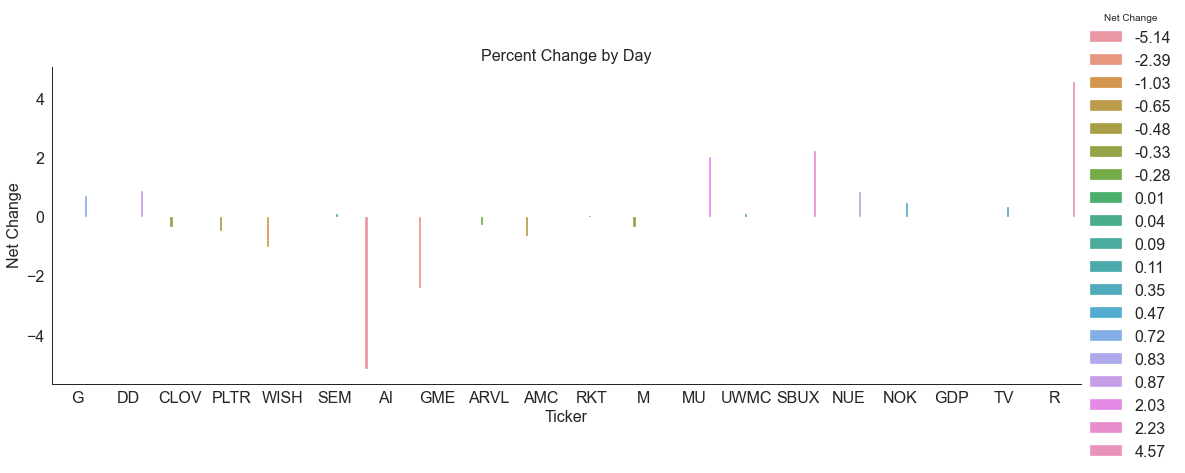

In [22]:
# % Price change in the stock price of the firms. 
sns.catplot(
    data=mentions_df,
    x='Ticker',
    y='Net Change',
    hue='Net Change',
    kind='bar',
    height=5, # make the plot 5 units high
    aspect=3).set(title='Percent Change by Day') # height should be three times width

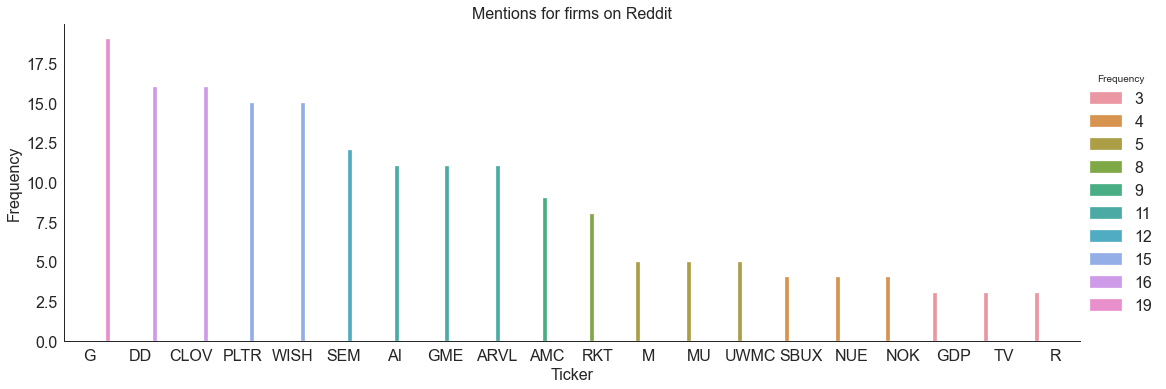

In [23]:
# Boxplot of the total frequency of each firm.
sns.catplot(
    data=mentions_df,
    x='Ticker',
    y='Frequency',
    hue='Frequency',
    kind='bar',
    height=5, # make the plot 5 units high
    aspect=3).set(title='Mentions for firms on Reddit') # height should be three times width

###### The purpose of the "Label" needs to be discussed. 

##### The label I chose to put on the CSV as it is a binary measurement to determine whether a firm was Up=1, meaning it had a % price change different than the day before. 

###### Or Down=0, where the % price change dipped than the day before. This I believe will help perform further analysis. 

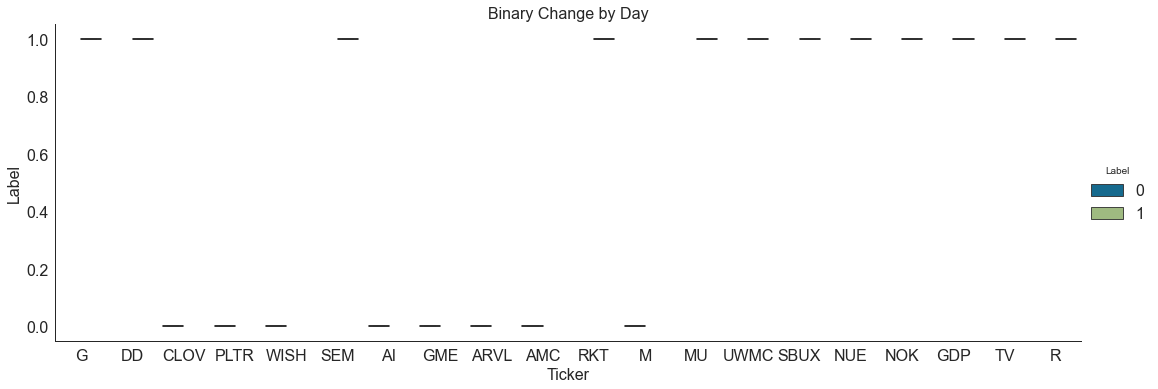

In [24]:
# Binary change in the stock price of the firms. 
sns.catplot(
    data=mentions_df,
    x='Ticker',
    y='Label',
    hue='Label',
    kind='box',
    height=5, # make the plot 5 units high
    aspect=3).set(title='Binary Change by Day') # height should be three times width

###### We can begin to get an understanding of the data. We can see already Tesla's stock has dropped but barely anyone spoke about it on Reddit. But the most spoke about firm UWMC, barely moved at a net change of 0.09%

###### I need to change the column "Industry" to a string in order to obtain the sentiment analysis of the data.

In [25]:
mentions_df['Industry'] = mentions_df['Industry'].astype(str)

###### Begin the sentiment analysis. I will get the polarity of senitments followed by the subjectivity of each. I will add these to the dataframe.

## Sentiment Analysis

### Finviz sentiment analysis

In [26]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [27]:
news

,Ticker,Date,Time,Headline,neg,neu,pos,compound
0,WISH,Aug-13-21,05:39PM,Why ContextLogic Stock Crashed Today,0.000,1.000,0.000,0.0000
1,WISH,Aug-13-21,04:40PM,"Dow, S&P 500 end at records Friday, finish wee...",0.000,1.000,0.000,0.0000
2,WISH,Aug-13-21,02:45PM,"Disney stock jumps, Airbnb falls, WISH sinks t...",0.120,0.684,0.196,0.3254
3,WISH,Aug-13-21,09:54AM,"Wish stock tanks, SoFi profit outlook disappoi...",0.232,0.309,0.459,0.6597
4,WISH,Aug-13-21,05:30AM,ContextLogic Stock Only Has One Trade Setup Af...,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
1872,GME,Jul-18-21,09:07AM,How Much More Does GameStop Have to Fall Befor...,0.000,1.000,0.000,0.0000
1873,GME,Jul-17-21,10:22AM,Beyond GameStop: Reddits WallStreetBets is Now...,0.000,1.000,0.000,0.0000
1874,GME,Jul-16-21,05:15PM,"Why AMC, GameStop, and Newegg Were All Over th...",0.000,1.000,0.000,0.0000
1875,GME,Jul-16-21,04:24PM,Want to Make $1 Million? Market Manipulation I...,0.168,0.744,0.088,-0.2942


In [28]:
unique_ticker_finviz = news['Ticker'].unique().tolist()
news_dict_finviz = {name: news.loc[news['Ticker'] == name] for name in unique_ticker_finviz}

values = []
for ticker in tickers: 
    dataframe = news_dict_finviz[ticker]
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df1 = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'News_Sentiment']) 
df1 = df1.set_index('Ticker')
df1 = df1.sort_values('News_Sentiment', ascending=False)
print (df1)

        News_Sentiment
Ticker                
WISH              0.24
PLTR              0.24
M                 0.18
UPST              0.16
SEM               0.16
NOK               0.15
MU                0.14
DIS               0.13
AMZN              0.13
CLOV              0.12
DD                0.11
SBUX              0.10
ARVL              0.10
UWMC              0.10
AI                0.09
G                 0.09
EBAY              0.08
GNW               0.08
GME               0.08
RKT               0.07


In [29]:
combined_df_with_news = pd.merge(mentions_df, news, on="Ticker") # Combined ticker data with vectorized words

### Reddit sentiment analysis

###### Here I will create a defintion which will get the sentiment scores through the library NLTK.Vader. I created 4 empty lists. Where in a for-loop I will add the computed sentiment to the lists. Following this, the lists will be added to the dataframe. 

In [30]:
# Create a function to get the sentiment scores. 
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [31]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [32]:
mentions_df['Polarity'] = mentions_df['Industry'].apply(getPolarity)
mentions_df['Subjectivity'] = mentions_df['Industry'].apply(getSubjectivity)

In [33]:
# Create a function to get sentiment scores
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [34]:
# Get sentiment scores
compound = []
neg = []
pos = []
neu = []
SIA = []

for i in range(0, len(mentions_df['Industry'])):
    SIA = getSIA(mentions_df['Industry'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])
    pos.append(SIA['pos'])

In [35]:
# Store the sentiment scores in the dataset
mentions_df['Compound'] = compound
mentions_df['Negative'] = neg
mentions_df['Neutral'] = neu
mentions_df['Positive'] = pos

In [36]:
mentions_df.head() # Observing the data.

,Ticker,Company_Name,Last Sale,Net Change,Label,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry,Frequency,Polarity,Subjectivity,Compound,Negative,Neutral,Positive
0,G,Genpact Limited Common Stock,$48.39,0.72,1,1.51%,9.056146e+09,Bermuda,2007.0,5663684,Consumer Services,Professional Services,19,0.1,0.1,0.0,0.0,1.0,0.0
1,DD,DuPont de Nemours Inc. Common Stock,$77.92,0.87,1,1.13%,4.165021e+10,NaN,2017.0,2757531,Capital Goods,Wholesale Distributors,16,0.0,0.0,0.0,0.0,1.0,0.0
2,CLOV,Clover Health Investments Corp. Class A Common...,$10.17,-0.33,0,-3.14%,4.481919e+09,United States,NaN,68090526,Health Care,Medical Specialities,16,0.0,0.0,0.0,0.0,1.0,0.0
3,PLTR,Palantir Technologies Inc. Class A Common Stock,$23.37,-0.48,0,-2.01%,4.388731e+10,NaN,2020.0,36591121,Technology,Retail: Computer Software & Peripheral Equipment,15,0.0,0.0,0.0,0.0,1.0,0.0
4,WISH,ContextLogic Inc. Class A Common Stock,$14.16,-1.03,0,-6.78%,8.750880e+09,United States,2020.0,4140302,Capital Goods,Recreational Products/Toys,15,0.0,0.0,0.0,0.0,1.0,0.0


###### Making a new list with the relevant data. I chose to use columns which hold numerical data. I looked through the categorical columns and determined that even if I transformed them to numerical data. Things like "Country" would not be relevant. 

In [37]:
for col in mentions_df.columns: # Determining column names so I can change them 
    print(col)

Ticker
Company_Name
Last Sale
Net Change
Label
% Change
Market Cap
Country
IPO Year
Volume
Sector
Industry
Frequency
Polarity
Subjectivity
Compound
Negative
Neutral
Positive


In [38]:
# list of columns which I am using for further analysis. 
keep_columns_Reddit = ['Volume', 'Net Change', 'Market Cap', 'Frequency', 'Polarity', 'Compound', 'Negative', 'Positive', 'Label']

In [39]:
# list of columns which I am using for further analysis. 
keep_columns_Finviz = ['Volume', 'Net Change', 'Market Cap', 'Frequency', 'neg', 'neu', 'pos', 'compound', 'Label']

In [40]:
ready_Reddit = mentions_df[keep_columns_Reddit]

In [41]:
ready_Finviz = combined_df_with_news[keep_columns_Finviz]

In [42]:
ready_Finviz.head() # Looking at the Finviz data that will be used for modeling

,Volume,Net Change,Market Cap,Frequency,neg,neu,pos,compound,Label
0,5663684,0.72,9.056146e+09,19,0.0,0.769,0.231,0.5106,1
1,5663684,0.72,9.056146e+09,19,0.0,0.569,0.431,0.6486,1
2,5663684,0.72,9.056146e+09,19,0.0,0.680,0.320,0.5106,1
3,5663684,0.72,9.056146e+09,19,0.0,1.000,0.000,0.0000,1
4,5663684,0.72,9.056146e+09,19,0.0,1.000,0.000,0.0000,1


In [43]:
ready_Reddit.head() # Looking at the Reddit data that will be used for modeling

,Volume,Net Change,Market Cap,Frequency,Polarity,Compound,Negative,Positive,Label
0,5663684,0.72,9.056146e+09,19,0.1,0.0,0.0,0.0,1
1,2757531,0.87,4.165021e+10,16,0.0,0.0,0.0,0.0,1
2,68090526,-0.33,4.481919e+09,16,0.0,0.0,0.0,0.0,0
3,36591121,-0.48,4.388731e+10,15,0.0,0.0,0.0,0.0,0
4,4140302,-1.03,8.750880e+09,15,0.0,0.0,0.0,0.0,0


In [44]:
# Create the feature data set for Reddit
X = ready_Reddit
X = np.array(X.drop(['Label'], 1))
# Create the target data set
y = np.array(ready_Reddit['Label'])

In [45]:
# Create the feature data set for Finviz news
X1 = ready_Finviz
X1 = np.array(X1.drop(['Label'], 1))
# Create the target data set
y1 = np.array(ready_Finviz['Label'])

###### Reddit

In [46]:
# Split the data into 80% training and 20% for testing the model. 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [47]:
# Create and train the model
model_LDR = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [48]:
predictions = model_LDR.predict(x_test) # Performing the modeling using LDR

predictions

array([1, 0, 1, 0])

In [49]:
# Show the model metrics

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4



###### Finviz

In [50]:
# Split the data into 80% training and 20% for testing the model. 
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [51]:
# Create and train the model
model_LDR = LinearDiscriminantAnalysis().fit(x_train1, y_train1)

In [52]:
predictions1 = model_LDR.predict(x_test1) # Performing the modeling using LDR

predictions1

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1])

In [53]:
# Show the model metrics

print(classification_report(y_test1, predictions1))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90       125
           1       0.88      0.98      0.92       151

    accuracy                           0.91       276
   macro avg       0.92      0.91      0.91       276
weighted avg       0.92      0.91      0.91       276



###### Having complied both the Ticker.csv with the relevant data for each company. I was able to create a new dataframe with the mentions attached. Having done so, I was able to see how popular a company is in real time, and see what they are trading at. Further I elected to get sentiment scores from the dataset to increase the number of features so as to see if price shifts were correlated with mentions within Reddit. . Of note, the dataset is unbalanced due to the nature of the market 3:1. Additionally, upon inspecting the sentiment scores. I do not believe the method I used to generate the sentiment was sensitive enough for the text that was analyzed. Further, I believe I will have to use a more specific dictionary for the subreddit to interpret the sentiment of users. 

###### A number of features were dropped that I believe did not have any bearing on the model. For instance, I removed both Ticker and companyname. However, I was looking at the 2 groups namely, groups that were down or up in the market. Which was designated by the 'Label' column. Additionally, Country, IPO Year, Sector, and Industry were not important for this model. In the future I may elect to include these. FInally, for Last Price, and Percentage change. I could not figure out a way to include them for the model, I had wanted to include them but my own skills prevented me from including them despite my research into how to include them. 

###### Moving forward there are several things I believe that need to be optimized for this model to effectively work. Some features that need to be added. And a sentiment analysis that needs to be catered to the subreddit I am looking at. 

In [54]:
import warnings
warnings.filterwarnings("ignore")

###### I want to prepare the seed for the random state. This ensues that the randoms numbers are generated in the same order. 

In [55]:
# Preparing Seed.
seed = 10

###### I need to prepare an empty list then add the models which I am interested in. As I am interested in predicting whether or not mentions in a subreddit predict a stock price changes. I believe this models would best fit the end goal in which I set. Choosing one however is dificult. 

In [56]:
# Create an empty list. Then append them to the list. For Reddit
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [57]:
# Create an empty list. Then append them to the list. For Finviz
models1 = []
models1.append(('LR', LogisticRegression()))
models1.append(('LDA', LinearDiscriminantAnalysis()))
models1.append(('KNN', KNeighborsClassifier()))
models1.append(('CART', DecisionTreeClassifier()))
models1.append(('NB', GaussianNB()))
models1.append(('SVM', SVC()))

###### I need to assess the performance of each model. In doing so I will need to do a "for loop" to iteratively assess the performance as I go through the 'models' list. The assessment then, is the process of performing a k-fold cross-validation each test to see the performance of each test. The k-fold cross validation is a go-to in the data science community as it has a better accuracy of whether or not a model is best fit for the dataset being used. This is due to the arbitrary way in which a data split is performed in a typical split and test model. The variance of which changes each time it is done. K-fold cross validation is the iterative way in which typical split and test model is expanded for better accuracy. 

###### I will need to create an empty results and names list. Then iteratively go through each name in the models list to find the accuracy. This is assigned to cv_results. Where it is appeneded to the empty list of results. Finally, I will report the mean accuracy and standard deviation.

In [58]:
# Assessing the models for Reddit 
# Assess the models. 
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=20, random_state=20)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.550000 (0.497494)
LDA: 0.750000 (0.433013)
KNN: 0.550000 (0.497494)
CART: 1.000000 (0.000000)
NB: 0.500000 (0.500000)
SVM: 0.600000 (0.489898)


In [59]:
# Assessing the models for Finviz
# Assess the models. 
results1 = []
names1 = []
scoring1 = 'accuracy'
for name1, model1 in models1:
    kfold1 = model_selection.KFold(n_splits=20, random_state=20)
    cv_results1 = model_selection.cross_val_score(model1, X1, y1, cv=kfold1, scoring=scoring1)
    results1.append(cv_results1)
    names1.append(name1)
    msg1 = "%s: %f (%f)" % (name1, cv_results1.mean(), cv_results1.std())
    print(msg1)

LR: 0.464152 (0.437606)
LDA: 0.704348 (0.348170)
KNN: 1.000000 (0.000000)
CART: 1.000000 (0.000000)
NB: 0.686914 (0.399337)
SVM: 0.704305 (0.375931)


###### To better assess the performance. I will create a boxplot to simply the interpretation of the models. 

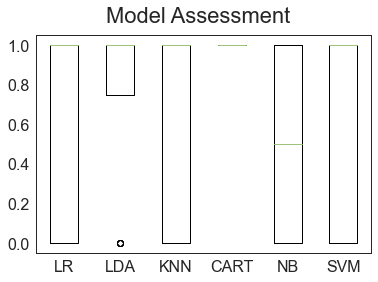

In [60]:
# Boxplot algorithm comparison for Reddit
fig = plt.figure()
fig.suptitle('Model Assessment')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

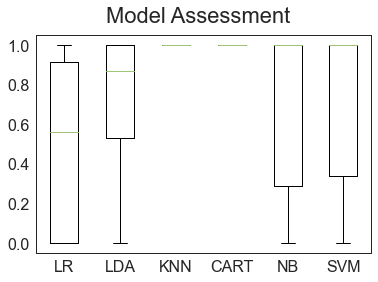

In [61]:
# Boxplot algorithm comparison for Finviz
fig = plt.figure()
fig.suptitle('Model Assessment')
ax = fig.add_subplot(111)
plt.boxplot(results1)
ax.set_xticklabels(names1)
plt.show()

###### The graph is alright. But, I'd like to see something with a little bit more oomph. 

###### In order to further visualize the data. I will have to configure the new dataframe in order to use Seaborn effectively.

###### The following is for Reddit. 

In [62]:
df_results = pd.DataFrame(data=results).T # Assigning the list "results" to a dataframe. 
df_results

,0,1,2,3,4,5
0,1.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,1.0,1.0,0.0
5,1.0,0.0,0.0,1.0,0.0,1.0
6,0.0,1.0,1.0,1.0,1.0,0.0
7,0.0,1.0,0.0,1.0,1.0,0.0
8,0.0,1.0,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,1.0,1.0,0.0


In [63]:
for col in df_results.columns: # Determining column names so I can change them 
    print(col)

0
1
2
3
4
5


In [64]:
new = df_results.rename(columns = {0:'LR', 1: 'LDA', 2: 'KNN', 3: 'CART', 4: 'NB', 5: 'SVM'})
new # Rename numerical columuns to columns names based on the model ran. 

,LR,LDA,KNN,CART,NB,SVM
0,1.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,1.0,1.0,0.0
5,1.0,0.0,0.0,1.0,0.0,1.0
6,0.0,1.0,1.0,1.0,1.0,0.0
7,0.0,1.0,0.0,1.0,1.0,0.0
8,0.0,1.0,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,1.0,1.0,0.0


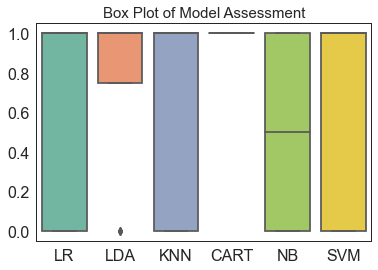

In [65]:
# Box plot of without datapoints for reference
ax = sns.boxplot(data=new, orient="v", palette="Set2")
plt.title('Box Plot of Model Assessment', fontsize=15)
plt.show()

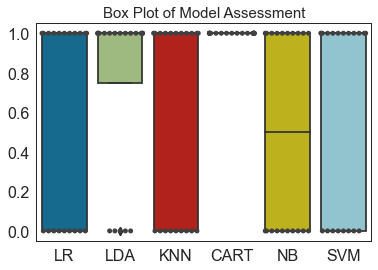

In [66]:
# Box plot with data points for reference.
ax = sns.boxplot(data=new)
ax = sns.swarmplot(data=new, color=".25")
plt.title('Box Plot of Model Assessment', fontsize=15)
plt.show()

###### The following is for Finviz

In [67]:
df_results1 = pd.DataFrame(data=results1).T # Assigning the list "results" to a dataframe. 
df_results1.head()

,0,1,2,3,4,5
0,1.000000,0.565217,1.0,1.0,0.000000,0.000000
1,1.000000,0.956522,1.0,1.0,0.550725,0.550725
2,0.898551,1.000000,1.0,1.0,1.000000,1.000000
3,0.000000,0.086957,1.0,1.0,0.000000,1.000000
4,0.000000,0.333333,1.0,1.0,0.000000,0.347826


In [68]:
for col in df_results1.columns: # Determining column names so I can change them 
    print(col)

0
1
2
3
4
5


In [69]:
new1 = df_results1.rename(columns = {0:'LR', 1: 'LDA', 2: 'KNN', 3: 'CART', 4: 'NB', 5: 'SVM'})
new1.head() # Rename numerical columuns to columns names based on the model ran. 

,LR,LDA,KNN,CART,NB,SVM
0,1.000000,0.565217,1.0,1.0,0.000000,0.000000
1,1.000000,0.956522,1.0,1.0,0.550725,0.550725
2,0.898551,1.000000,1.0,1.0,1.000000,1.000000
3,0.000000,0.086957,1.0,1.0,0.000000,1.000000
4,0.000000,0.333333,1.0,1.0,0.000000,0.347826


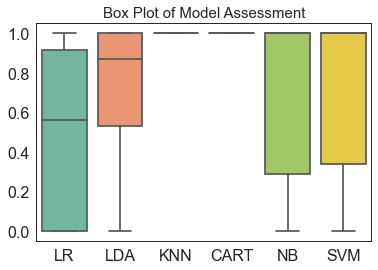

In [70]:
# Box plot of without datapoints for reference
ax = sns.boxplot(data=new1, orient="v", palette="Set2")
plt.title('Box Plot of Model Assessment', fontsize=15)
plt.show()

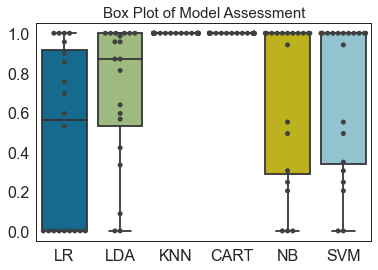

In [71]:
# Box plot with data points for reference.
ax = sns.boxplot(data=new1)
ax = sns.swarmplot(data=new1, color=".25")
plt.title('Box Plot of Model Assessment', fontsize=15)
plt.show()

###### On evaluating a model. I chose to look at 6 different models as there are benefits to each one. Some are practiced very often and others not as much. Although I believe that I could of looked at just 3 models. I wanted more practice in assessing the models accuracy and strengths on the dataset. 

###### The reddit API I use is dynamic in that in takes comments from real-time and performs the functions which I have stated above. That being said. The outcome changes as the comments are fluid and not static. What I have noticed is that common language spoke has a greater predicability than the language typically used in the subreddit. Which confirms my suspicions that I need a more sensitive dictionary for the subreddit. I researched some ways in which to implement different dictionaries but I was not successful. 

###### Thus I decided to move on and perform my model evaluation and assessment on the 6 selected models. My hypothesis remains the same as before in that I believe subreddit mentions have a corollary involement with price shifts on the stock market. That "Label" whose designations 0 = down in the market, and 1 = up in the market with the added mentions should have some prophetic insight in market shifts before they happen. 

###### Based on the the current sentiment analysis methodology I used and the 6 models I chose to evaluate. Logistic regression had a combined accuracy of 75% with a standard deviation of 43%. Linear Discriminant Analysis too has a accuracy rate of 75% and a standard deviation of 43%. The K-Neighbors Classifier has the lowest accuracy of 60% and a standard deviation of 48% The Decision Tree Classifier has a 100% accuracy, while this sounds good, I believe this is due to overfitting of the data. The Gaussian Naive Bayes model had a accuracy of 70% and a standard deviation of 45%. Lastly, the SVM model had an accuracy of 75% with an standard deviation of 43%. The variances still for each respective test is extremely high. This I think is due to the quality of the data itself. As I explored testing the models. I came to a further understanding that. Besides a more curated approach to the senitment analysis. I may have to redo some data preparation in order to effectively utilize predictive models such as the ones I just used. 

# Conclusion

I was not able to obtain time-series data for the kind of hypothesis I was proposing. Although I am sure there is a way, it is beyond my skillset currently. For question 3 though, I was able to find an answer...sort of. Finviz is a financial news website that aggregates a multitude of financial information as well as financial news. Thus, I ventured to scrape the website for relevant data as the news there is from official news outlets. 

Both the Reddit API and the Finviz API both pull data in realtime. So while we can't directly see the delay between sentiment and price change. We can see how differences in sentiment between both APIs may predict stock price changes. And so, we can measure in paralell how sentiment affects price change. 

Regarding both sentiments I will use the Decision Tree Classifier to compare the differences each other. For the Reddit sentiment, I had a accuracy score of 90%. The Finviz sentiment, I had an accuracy score of 100%. Interestingly, I had a depreceated accuracy scores for the Reddit Sentiment, and nearly 100% for the news outlets. 

I have several ideas as to why this may have occured. First, as one thing I have already mentioned before. Is that the effciency of the sentiment analyzer I used for the Reddit was not sensitive enough for the language of the subreddit. However, as I ventured to perform the Finviz, I was finding that perhaps it may not be the sentiment analyzer but the action of vectorizing the words. I performed the Finviz sentiment differently than Reddit to see the difference. In doing so I believe that, the way in which I wrangled the data for the sentiment analysis may be at fault. This is think is reflective due to the higher effciency for the Finviz models than the Reddit models. 

Conversely, what I could be seeing with the higher efficiency in the Finviz sentiments. Is actual differences between these two sources. For Finviz, as it is a news aggregation site. The news outlets reach out to more retail investors than Reddit. Reddit retail investors may not be the proper push for enough volume changes in a stock to really effect the price change. And news outlets have traditionally been used for multiple generations of retail investors. It also makes sense that perhaps this observation is real. 

Ultimately, I found that both sentiments have effects on stock prices. But, news outlets had a better predictive measure than Reddit. I believe it is due to the accessibility of Reddit to have real change on stock price. 